In [3]:
# Library Imports 
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import my_functions as mf
from scipy.optimize import curve_fit
from scipy.fftpack import fft, ifft, fftfreq
from scipy.special import voigt_profile
from scipy.signal import convolve
import re
importlib.reload(mf)
from collections import defaultdict

## FUNCTIONS ##

In [2]:
def read_B_field(file_name):
    match = re.search(r'fld_([0-9.]+)', file_name)
    if match: 
        
        b_field = float(match.group(1).strip("."))
        return b_field
    else: 
        print("Error: field value not found in filename.")

## Data Path ## 

In [4]:
data_path = "data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/"
data_file ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 21-07-47_freq_195.11847_rng_36.6852_gain_30_fld_0.0.csv"

## SINGLE SPECTRUM ##

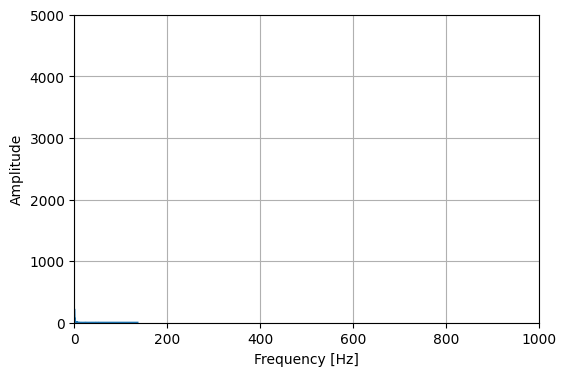

<Figure size 640x480 with 0 Axes>

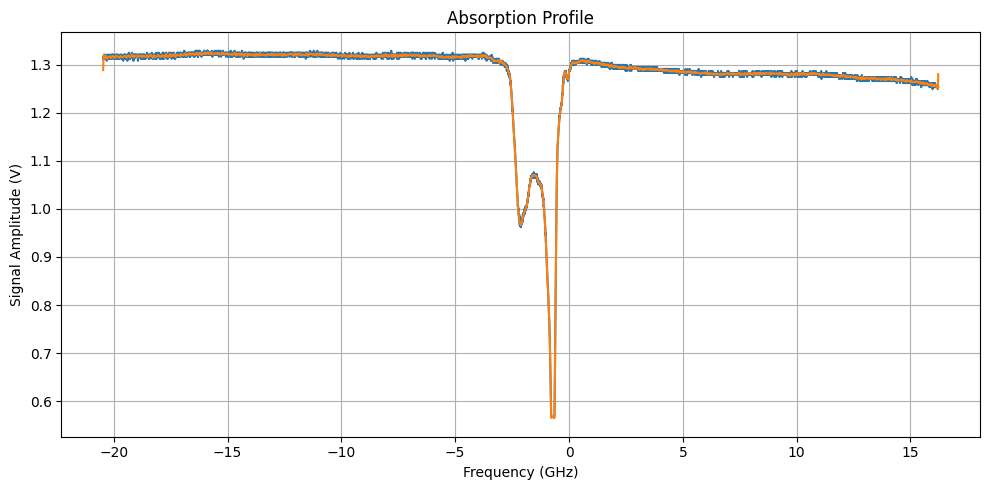

In [5]:

# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9
cleaned = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=True)

# Plot absorption profile
plt.figure(figsize=(10, 5))
plt.plot(freq_axis_GHz, voltage)
plt.plot(freq_axis_GHz, cleaned)
plt.xlabel("Frequency (GHz)")
plt.ylabel("Signal Amplitude (V)")
plt.title("Absorption Profile")
plt.grid(True)
plt.tight_layout()
plt.show()




## 2D SPECTRA W MAGNETIC FIELD ## 

In [116]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    voltage = mf.low_pass_band_filter_fft(20,freq_axis_GHz,voltage,plot_check=False)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]


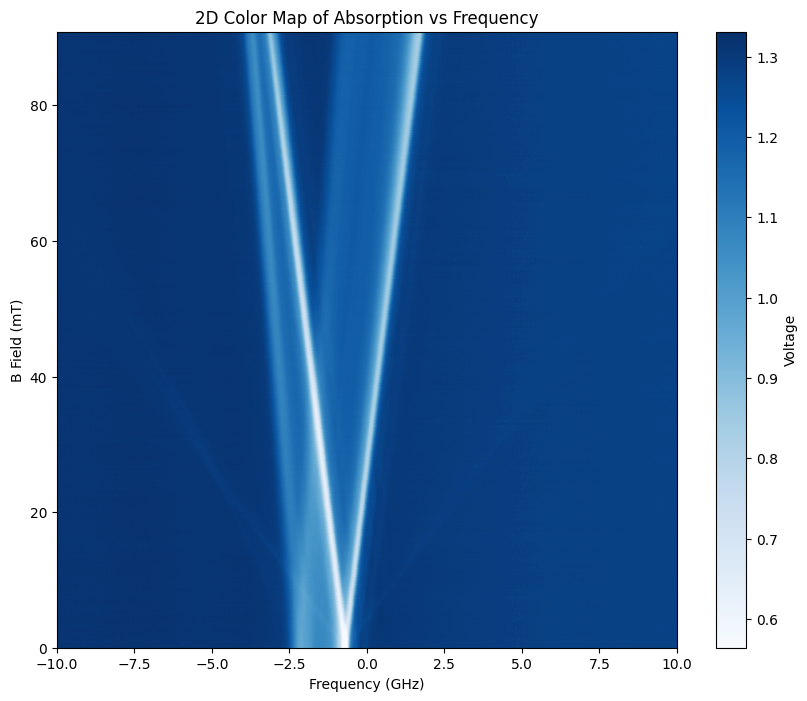

In [119]:
# plot 
plt.figure(figsize=(10,8))
plt.pcolormesh(freq_axis_GHz, fields*1000, voltages, shading='auto', cmap='Blues')
#plt.pcolormesh(fields*1000, freq_axis_GHz, voltages.T, shading='auto', cmap='Blues')
#plt.ylim([80,90])
plt.xlim([-10, 10])
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")
plt.show()


## Peak Tracking ##

In [157]:
## Lorentzian ## 
# Initialize a list to store each field's dips separately
all_dips_1 = []

# Extract and store linewidth features for each field
for voltage, B in zip(voltages, fields): 
    # Extract features for the current voltage and magnetic field
    features = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=0.02, min_prominence=0.01, to_print=False)

    # Prepare a dictionary for the current magnetic field
    dips_at_B = {
        "B_field": float(B),
        "f_dips": [],
        "fwhms": [],
        "depths": [],
        "indices": [],
        "s_fit": [],
        "signal_at_dips":[]
    }
    # Add each dip feature
    for idx, f in enumerate(features):
        try:
          if len(features)> 10: 
            raise ValueError("WARNING TOO MANY FITS")
        except ValueError as ve: 
           print(ve)
        
        # plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz" + f' B = {B:.4f} T')
        f_dip = float(f["f_dip"])
        fwhm = float(f["FWHM"]) * 1e3  # Convert FWHM to MHz
        depth = float(f["depth"])
        s_fit = f["s_fit"]

        # Find the closest point in the original frequency array
        idx_closest = (np.abs(freq_axis_GHz - f_dip)).argmin()
        signal_at_dip = voltage[idx_closest]
        print(f"Signal at dip frequency ({f_dip:.6f} GHz): {signal_at_dip:.6f}")

       # print(s_fit)
        # Store individual dip data
        dips_at_B["f_dips"].append(f_dip)
        dips_at_B["fwhms"].append(fwhm)
        dips_at_B["depths"].append(depth)
        dips_at_B["indices"].append(idx)
        dips_at_B["signal_at_dips"].append(signal_at_dip)

        
    # Append the structured dips for this B field
    all_dips_1.append(dips_at_B)

Signal at dip frequency (-3.662139 GHz): 1.056576
Signal at dip frequency (-0.467311 GHz): 1.181968
Signal at dip frequency (1.636709 GHz): 0.836822
Signal at dip frequency (16.195745 GHz): 1.250441
Signal at dip frequency (-2.112875 GHz): 0.965654
Signal at dip frequency (-0.654283 GHz): 0.564643
Signal at dip frequency (-0.056362 GHz): 1.269791
Signal at dip frequency (16.196073 GHz): 1.249928
Signal at dip frequency (-2.106189 GHz): 0.965776
Signal at dip frequency (-0.655260 GHz): 0.564348
Signal at dip frequency (-0.050918 GHz): 1.269796
Signal at dip frequency (16.196753 GHz): 1.249810
Signal at dip frequency (-2.131313 GHz): 0.969016
Signal at dip frequency (-0.659052 GHz): 0.564973
Signal at dip frequency (-0.033802 GHz): 1.272195
Signal at dip frequency (16.196815 GHz): 1.252921
Signal at dip frequency (-2.139494 GHz): 0.967747
Signal at dip frequency (-0.659248 GHz): 0.564940
Signal at dip frequency (16.197377 GHz): 1.252797
Signal at dip frequency (-2.116566 GHz): 0.968765
S

In [172]:
# Initialize a list to store each field's dips separately
all_dips_2 = []

# Extract and store linewidth features for each field
for voltage, B in zip(voltages, fields): 
    # Extract features for the current voltage and magnetic field
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.01, to_print=False)

    # Prepare a dictionary for the current magnetic field
    dips_at_B = {
        "B_field": float(B),
        "f_dips": [],
        "fwhms": [],
        "depths": [],
        "indices": [],
        "signal_at_dips":[]
    }

    # Add each dip feature
    for f in features:
        f_dip = float(f["f_dip"])
        fwhm = float(f["FWHM"]) * 1e3  # Convert FWHM to MHz
        depth = float(f.get("depth", 0))  # Use 0 if depth is not present
        idx = int(f["index"])

        # Find the closest point in the original frequency array
        idx_closest = (np.abs(freq_axis_GHz - f_dip)).argmin()
        signal_at_dip = voltage[idx_closest]
        print(f"Signal at dip frequency ({f_dip:.6f} GHz): {signal_at_dip:.6f}")
        
        # Store individual dip data
        dips_at_B["f_dips"].append(f_dip)
        dips_at_B["fwhms"].append(fwhm)
        dips_at_B["depths"].append(depth)
        dips_at_B["indices"].append(idx)
        dips_at_B["signal_at_dips"].append(signal_at_dip)
        

    # Append the structured dips for this B field
    all_dips_2.append(dips_at_B)


Signal at dip frequency (-3.661646 GHz): 1.056576
Signal at dip frequency (-3.093912 GHz): 0.876769
Signal at dip frequency (-0.469065 GHz): 1.181968
Signal at dip frequency (1.635973 GHz): 0.836822
Signal at dip frequency (-2.113281 GHz): 0.965654
Signal at dip frequency (-0.653395 GHz): 0.564643
Signal at dip frequency (-0.056168 GHz): 1.269791
Signal at dip frequency (-2.105908 GHz): 0.965776
Signal at dip frequency (-0.653395 GHz): 0.564176
Signal at dip frequency (-0.052482 GHz): 1.269796
Signal at dip frequency (-2.131714 GHz): 0.969016
Signal at dip frequency (-0.657081 GHz): 0.564855
Signal at dip frequency (-0.034049 GHz): 1.272195
Signal at dip frequency (-2.139087 GHz): 0.967747
Signal at dip frequency (-0.657081 GHz): 0.564884
Signal at dip frequency (-2.116968 GHz): 0.968765
Signal at dip frequency (-0.660768 GHz): 0.564904
Signal at dip frequency (-2.128027 GHz): 0.972070
Signal at dip frequency (-0.664454 GHz): 0.565116
Signal at dip frequency (-2.098535 GHz): 0.974462
S

In [149]:
print(all_dips_1)
print(all_dips_2)

[{'B_field': 0.0, 'f_dips': [-3.6621390257887962, -0.46731127219874974, 1.6367091784437333, 16.195744576794173], 'fwhms': [863.5585067501466, 109.64523881523161, 77.87682031184823, 1361.7910400076244], 'depths': [1.7271156047453229, 0.030949616738602644, 0.017090638340049088, 20.774918940764977], 'indices': [0, 1, 2, 3]}, {'B_field': 0.0, 'f_dips': [-2.112875224253921, -0.6542828737997778, -0.056361899002144125, 16.19607338429622], 'fwhms': [38.07814699675315, 1267.5631073086636, 544.4502336302475, 1191.6355621138514], 'depths': [0.0025094662801806535, 14.0577372869892, 0.18248212914251727, 17.359286271056884], 'indices': [0, 1, 2, 3]}, {'B_field': 0.00030333333333333335, 'f_dips': [-2.1061894285544267, -0.655259698764459, -0.050918374624463886, 16.196753076394927], 'fwhms': [723.3359186993558, 1649.1727676535504, 37.11309994522358, 1299.9602187901692], 'depths': [1.1267013559129504, 28.938309615942387, 0.00334233523275054, 21.81113306523201], 'indices': [0, 1, 2, 3]}, {'B_field': 0.00

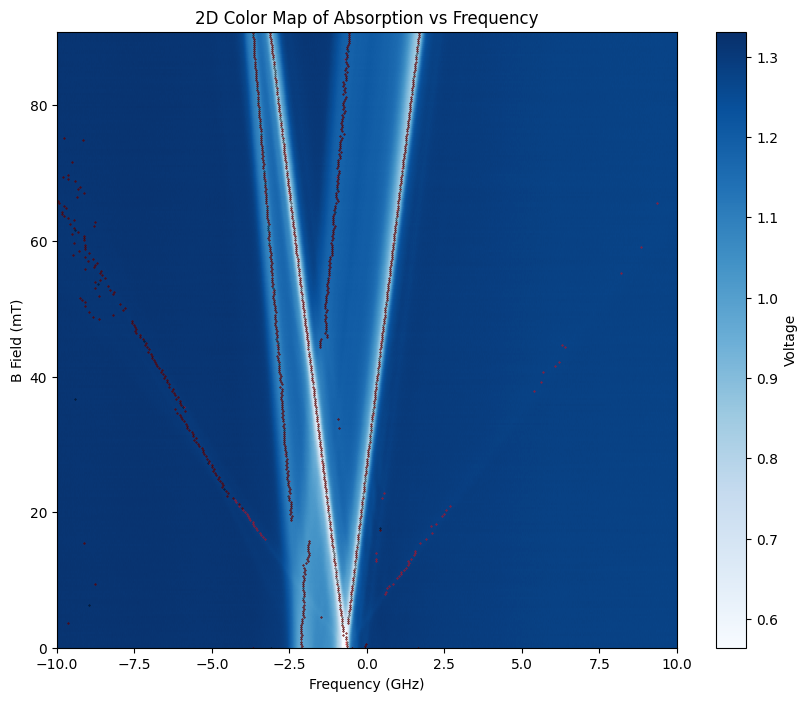

In [145]:
# Plot the 2D colormap of absorption
plt.figure(figsize=(10, 8))
plt.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")

## Lorentzian ## 
# Plot each dip as an individual point to track separately

for dip_data in all_dips_1:
    B_field = dip_data["B_field"] * 1000  # Convert to mT for plotting
    f_dips = dip_data["f_dips"]
    depths = dip_data["depths"]
    
    # Plot each dip frequency as a black point
    plt.scatter(f_dips, [B_field]* len(f_dips), color="r", s=0.1, label="Frequency Dip")
## Numerical ## 
# Plot each dip as an individual point to track separately
for dip_data in all_dips_2:
    B_field = dip_data["B_field"] * 1000  # Convert to mT for plotting
    f_dips = dip_data["f_dips"]

    # Plot each dip frequency as a black point
    plt.scatter(f_dips, [B_field] * len(f_dips), color="k", s=0.1, label="Frequency Dip")
plt.xlim([-10, 10])
plt.show()



## Grouping ###

In [186]:
## LOrentzian ## 
# Adjustable window size for grouping peaks by signal amplitude
signal_window = 0.15  # Adjust this based on signal variability

# Step 1: Group peaks by signal amplitude using a window
peak_groups = []

for dip_data in all_dips_1:
    B_field = dip_data["B_field"]
    f_dips = dip_data["f_dips"]
    depths = dip_data["depths"]
    signals = dip_data["signal_at_dips"]
    
    for f_dip, depth, signal_at_dip in zip(f_dips, depths, signals):
        # Check if the dip can be grouped with an existing peak group
        grouped = False
        for group in peak_groups:
            # Check if the signal is within the specified window of the group
            if abs(group["reference_signal"] - signal_at_dip) < signal_window:
                group["f_dips"].append(f_dip)
                group["B_fields"].append(B_field)
                group["depths"].append(depth)
                group["signals"].append(signal_at_dip)
                grouped = True
                break
        
        # If not grouped, create a new group
        if not grouped:
            peak_groups.append({
                "reference_signal": signal_at_dip,
                "f_dips": [f_dip],
                "B_fields": [B_field],
                "depths": [depth],
                "signals": [signal_at_dip]
            })

# Print grouped peaks for verification
for i, group in enumerate(peak_groups):
    print(f"Group {i+1} (Reference Signal: {group['reference_signal']:.4f}):")
    for f_dip, B, signal in zip(group["f_dips"], group["B_fields"], group["signals"]):
        print(f"  B: {B:.4f} T, f_dip: {f_dip:.4f} GHz, Signal: {signal:.4f}")
    print("-" * 50)




Group 1 (Reference Signal: 1.0566):
  B: 0.0000 T, f_dip: -3.6621 GHz, Signal: 1.0566
  B: 0.0000 T, f_dip: -0.4673 GHz, Signal: 1.1820
  B: 0.0000 T, f_dip: -2.1129 GHz, Signal: 0.9657
  B: 0.0003 T, f_dip: -2.1062 GHz, Signal: 0.9658
  B: 0.0006 T, f_dip: -2.1313 GHz, Signal: 0.9690
  B: 0.0009 T, f_dip: -2.1395 GHz, Signal: 0.9677
  B: 0.0012 T, f_dip: -2.1166 GHz, Signal: 0.9688
  B: 0.0015 T, f_dip: -2.1295 GHz, Signal: 0.9721
  B: 0.0018 T, f_dip: -2.0985 GHz, Signal: 0.9745
  B: 0.0021 T, f_dip: -2.1135 GHz, Signal: 0.9737
  B: 0.0024 T, f_dip: -2.1161 GHz, Signal: 0.9753
  B: 0.0027 T, f_dip: -2.1204 GHz, Signal: 0.9774
  B: 0.0030 T, f_dip: -2.1195 GHz, Signal: 0.9781
  B: 0.0033 T, f_dip: -2.1232 GHz, Signal: 0.9801
  B: 0.0036 T, f_dip: -2.0970 GHz, Signal: 0.9825
  B: 0.0039 T, f_dip: -2.0857 GHz, Signal: 0.9817
  B: 0.0042 T, f_dip: -2.0919 GHz, Signal: 0.9839
  B: 0.0046 T, f_dip: -2.0420 GHz, Signal: 0.9833
  B: 0.0046 T, f_dip: -1.4701 GHz, Signal: 1.0469
  B: 0.0049 T,

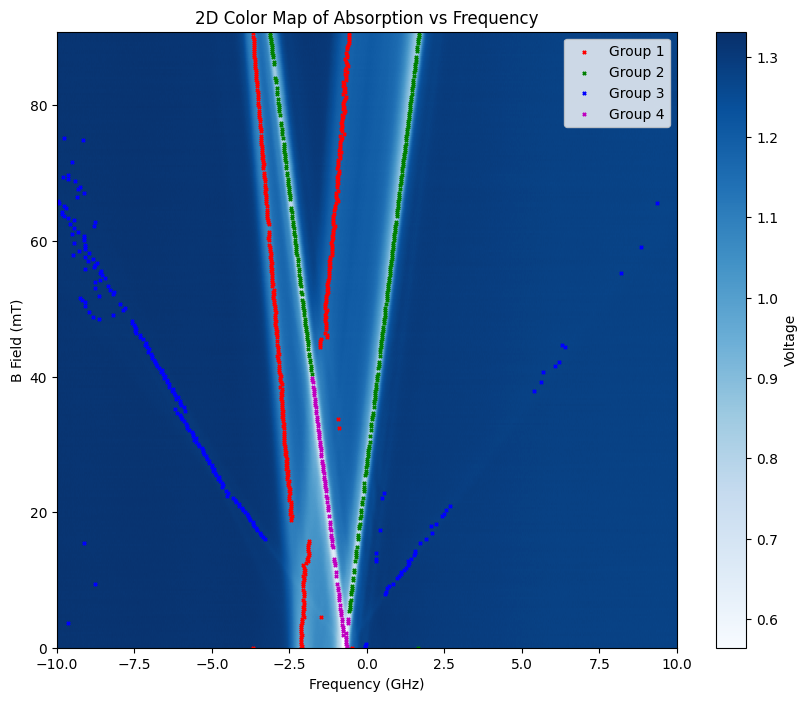

In [187]:
# Step 2: Plot the 2D colormap of absorption
plt.figure(figsize=(10, 8))
plt.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")

# Step 3: Plot grouped peaks with different colors
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
for i, group in enumerate(peak_groups):
    B_fields = np.array(group["B_fields"]) * 1000  # Convert to mT
    f_dips = np.array(group["f_dips"])
    
    # Plot peaks of each group with a distinct color
    plt.scatter(f_dips, B_fields, color=colors[i % len(colors)],marker ='x', s=5, label=f"Group {i+1}")

plt.xlim([-10, 10])
plt.legend()
plt.show()

In [176]:
## Numerical ## 
# Adjustable window size for grouping peaks by signal amplitude
signal_window = 0.15  # Adjust this based on signal variability

# Step 1: Group peaks by signal amplitude using a window
peak_groups = []

for dip_data in all_dips_2:
    B_field = dip_data["B_field"]
    f_dips = dip_data["f_dips"]
    depths = dip_data["depths"]
    signals = dip_data["signal_at_dips"]
    
    for f_dip, depth, signal_at_dip in zip(f_dips, depths, signals):
        # Check if the dip can be grouped with an existing peak group
        grouped = False
        for group in peak_groups:
            # Check if the signal is within the specified window of the group
            if abs(group["reference_signal"] - signal_at_dip) < signal_window:
                group["f_dips"].append(f_dip)
                group["B_fields"].append(B_field)
                group["depths"].append(depth)
                group["signals"].append(signal_at_dip)
                grouped = True
                break
        
        # If not grouped, create a new group
        if not grouped:
            peak_groups.append({
                "reference_signal": signal_at_dip,
                "f_dips": [f_dip],
                "B_fields": [B_field],
                "depths": [depth],
                "signals": [signal_at_dip]
            })
    
# Print grouped peaks for verification
for i, group in enumerate(peak_groups):
    print(f"Group {i+1} (Reference Signal: {group['reference_signal']:.4f}):")
    for f_dip, B, signal in zip(group["f_dips"], group["B_fields"], group["signals"]):
        print(f"  B: {B:.4f} T, f_dip: {f_dip:.4f} GHz, Signal: {signal:.4f}")
    print("-" * 50)



Group 1 (Reference Signal: 1.0566):
  B: 0.0000 T, f_dip: -3.6616 GHz, Signal: 1.0566
  B: 0.0000 T, f_dip: -0.4691 GHz, Signal: 1.1820
  B: 0.0000 T, f_dip: -2.1133 GHz, Signal: 0.9657
  B: 0.0003 T, f_dip: -2.1059 GHz, Signal: 0.9658
  B: 0.0006 T, f_dip: -2.1317 GHz, Signal: 0.9690
  B: 0.0009 T, f_dip: -2.1391 GHz, Signal: 0.9677
  B: 0.0012 T, f_dip: -2.1170 GHz, Signal: 0.9688
  B: 0.0015 T, f_dip: -2.1280 GHz, Signal: 0.9721
  B: 0.0018 T, f_dip: -2.0985 GHz, Signal: 0.9745
  B: 0.0021 T, f_dip: -2.1133 GHz, Signal: 0.9737
  B: 0.0024 T, f_dip: -2.1170 GHz, Signal: 0.9753
  B: 0.0027 T, f_dip: -2.1207 GHz, Signal: 0.9774
  B: 0.0030 T, f_dip: -2.1207 GHz, Signal: 0.9781
  B: 0.0033 T, f_dip: -2.1243 GHz, Signal: 0.9801
  B: 0.0036 T, f_dip: -2.0985 GHz, Signal: 0.9825
  B: 0.0039 T, f_dip: -2.0875 GHz, Signal: 0.9817
  B: 0.0042 T, f_dip: -2.0912 GHz, Signal: 0.9839
  B: 0.0046 T, f_dip: -2.0432 GHz, Signal: 0.9833
  B: 0.0046 T, f_dip: -1.4718 GHz, Signal: 1.0469
  B: 0.0049 T,

/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/myvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


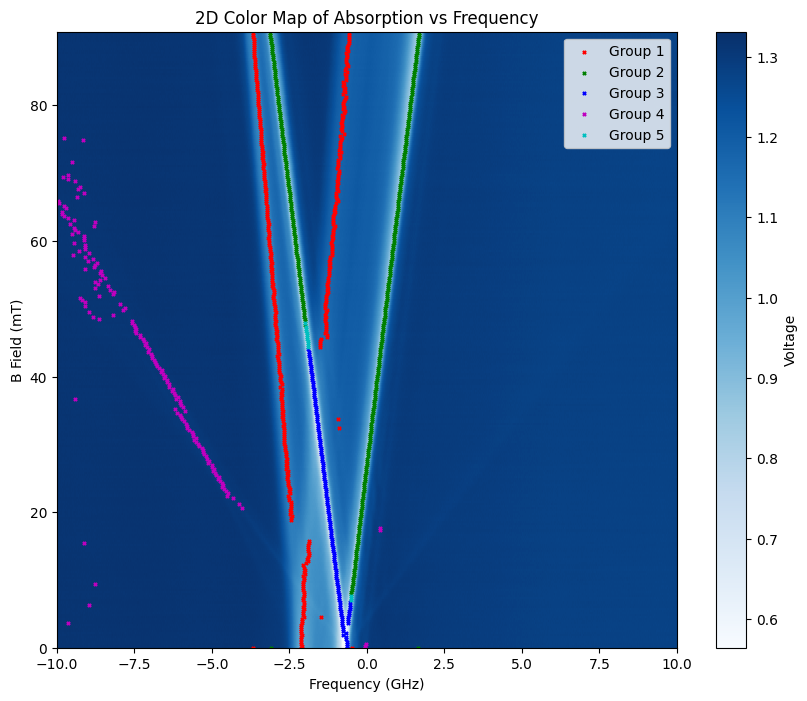

In [177]:
# Step 2: Plot the 2D colormap of absorption
plt.figure(figsize=(10, 8))
plt.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")

# Step 3: Plot grouped peaks with different colors
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
for i, group in enumerate(peak_groups):
    B_fields = np.array(group["B_fields"]) * 1000  # Convert to mT
    f_dips = np.array(group["f_dips"])
    
    # Plot peaks of each group with a distinct color
    plt.scatter(f_dips, B_fields, color=colors[i % len(colors)],marker ='x', s=5, label=f"Group {i+1}")

plt.xlim([-10, 10])
plt.legend()
plt.show()

Group 1 (Ordered Position: 1):
  B: 0.0000 T, f_dip: 1.6367 GHz, Signal: 0.8368
  B: 0.0000 T, f_dip: -0.6543 GHz, Signal: 0.5646
  B: 0.0003 T, f_dip: -0.6553 GHz, Signal: 0.5643
  B: 0.0006 T, f_dip: -0.6591 GHz, Signal: 0.5650
  B: 0.0009 T, f_dip: -0.6592 GHz, Signal: 0.5649
  B: 0.0012 T, f_dip: -0.6599 GHz, Signal: 0.5649
  B: 0.0015 T, f_dip: -0.6638 GHz, Signal: 0.5651
  B: 0.0018 T, f_dip: -0.7699 GHz, Signal: 0.5656
  B: 0.0021 T, f_dip: -0.6753 GHz, Signal: 0.5660
  B: 0.0024 T, f_dip: -0.7752 GHz, Signal: 0.5663
  B: 0.0027 T, f_dip: -0.7611 GHz, Signal: 0.5673
  B: 0.0030 T, f_dip: -0.7789 GHz, Signal: 0.5695
  B: 0.0033 T, f_dip: -0.7903 GHz, Signal: 0.5739
  B: 0.0036 T, f_dip: -0.6241 GHz, Signal: 0.6740
  B: 0.0039 T, f_dip: -0.8065 GHz, Signal: 0.5834
  B: 0.0042 T, f_dip: -0.8137 GHz, Signal: 0.5869
  B: 0.0046 T, f_dip: -2.0420 GHz, Signal: 0.9833
  B: 0.0049 T, f_dip: -0.8354 GHz, Signal: 0.5970
  B: 0.0052 T, f_dip: -0.8398 GHz, Signal: 0.6019
  B: 0.0055 T, f_dip

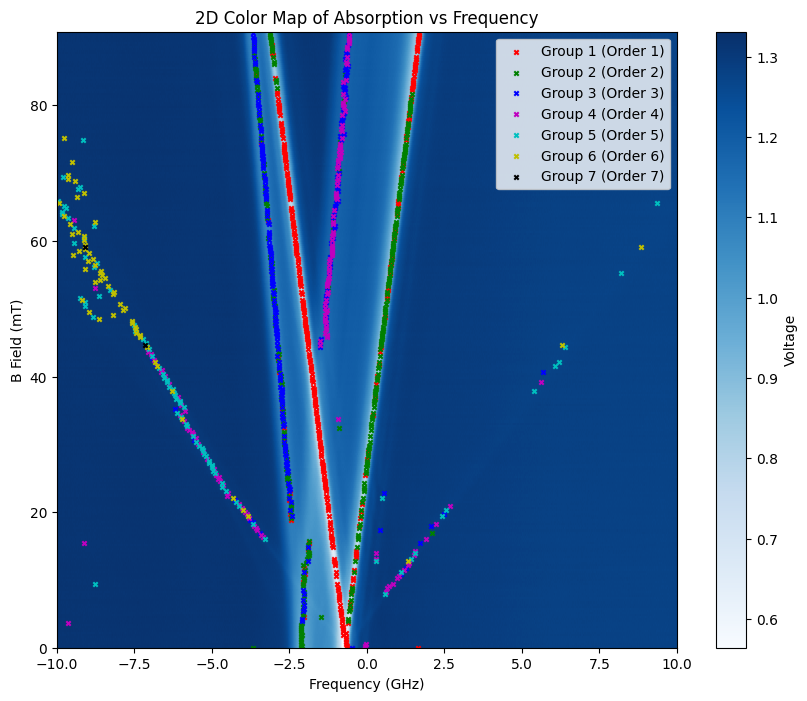

In [188]:
## Lorentzian ## 
# Adjustable window size for grouping peaks by signal amplitude
signal_window = 0.08  # Adjust this based on signal variability

# Step 1: Group peaks by ordering based on signal amplitude (smallest to largest)
peak_groups = []

for dip_data in all_dips_1:
    B_field = dip_data["B_field"]
    f_dips = np.array(dip_data["f_dips"])
    depths = np.array(dip_data["depths"])
    signals = np.array(dip_data["signal_at_dips"])
    
    # Sort peaks within the spectrum by signal amplitude (ascending order)
    sorted_indices = np.argsort(signals)
    sorted_f_dips = f_dips[sorted_indices]
    sorted_signals = signals[sorted_indices]
    sorted_depths = depths[sorted_indices]
    
    # Group peaks by their ordered position (1st, 2nd, 3rd, etc.)
    for order, (f_dip, depth, signal_at_dip) in enumerate(zip(sorted_f_dips, sorted_depths, sorted_signals)):
        # Check if the ordered group already exists
        if order >= len(peak_groups):
            peak_groups.append({
                "order": order + 1,
                "f_dips": [],
                "B_fields": [],
                "depths": [],
                "signals": []
            })

        # Append the ordered peak data to the respective group
        peak_groups[order]["f_dips"].append(f_dip)
        peak_groups[order]["B_fields"].append(B_field)
        peak_groups[order]["depths"].append(depth)
        peak_groups[order]["signals"].append(signal_at_dip)

# Print grouped peaks for verification
for i, group in enumerate(peak_groups):
    print(f"Group {i+1} (Ordered Position: {group['order']}):")
    for f_dip, B, signal in zip(group["f_dips"], group["B_fields"], group["signals"]):
        print(f"  B: {B:.4f} T, f_dip: {f_dip:.4f} GHz, Signal: {signal:.4f}")
    print("-" * 50)

# Step 2: Plot the 2D colormap of absorption
plt.figure(figsize=(10, 8))
plt.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")

# Step 3: Plot grouped peaks with different colors
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
for i, group in enumerate(peak_groups):
    B_fields = np.array(group["B_fields"]) * 1000  # Convert to mT
    f_dips = np.array(group["f_dips"])
    
    # Plot peaks of each group with a distinct color
    plt.scatter(f_dips, B_fields, color=colors[i % len(colors)], marker='x', s=10, label=f"Group {i+1} (Order {group['order']})")

plt.xlim([-10, 10])
plt.legend()
plt.show()


## Cluster peak Fittign ## 

In [150]:
from sklearn.cluster import DBSCAN
import numpy as np

# Parameters for clustering
frequency_threshold = 1  # Adjust this for peak grouping (GHz)

# Collect all dips across magnetic fields
all_peaks = []

for dip_data in all_dips_1:
    B_field = dip_data["B_field"]
    f_dips = dip_data["f_dips"]
    for f_dip in f_dips:
        all_peaks.append((B_field, f_dip))

# Convert to numpy array for clustering
all_peaks = np.array(all_peaks)

# Cluster the peak frequencies to group similar peaks
db = DBSCAN(eps=frequency_threshold, min_samples=1).fit(all_peaks[:, 1].reshape(-1, 1))

# Organize clusters
peak_clusters = {}
for label in set(db.labels_):
    cluster_indices = np.where(db.labels_ == label)[0]
    peak_clusters[label] = all_peaks[cluster_indices]

# Print clustered peaks
for cluster, peaks in peak_clusters.items():
    print(f"Cluster {cluster}:")
    for B_field, f_dip in peaks:
        print(f"  B: {B_field:.4f} T, f_dip: {f_dip:.4f} GHz")


Cluster 0:
  B: 0.0000 T, f_dip: -3.6621 GHz
  B: 0.0000 T, f_dip: -0.4673 GHz
  B: 0.0000 T, f_dip: 1.6367 GHz
  B: 0.0000 T, f_dip: -2.1129 GHz
  B: 0.0000 T, f_dip: -0.6543 GHz
  B: 0.0000 T, f_dip: -0.0564 GHz
  B: 0.0003 T, f_dip: -2.1062 GHz
  B: 0.0003 T, f_dip: -0.6553 GHz
  B: 0.0003 T, f_dip: -0.0509 GHz
  B: 0.0006 T, f_dip: -2.1313 GHz
  B: 0.0006 T, f_dip: -0.6591 GHz
  B: 0.0006 T, f_dip: -0.0338 GHz
  B: 0.0009 T, f_dip: -2.1395 GHz
  B: 0.0009 T, f_dip: -0.6592 GHz
  B: 0.0012 T, f_dip: -2.1166 GHz
  B: 0.0012 T, f_dip: -0.6599 GHz
  B: 0.0015 T, f_dip: -2.1295 GHz
  B: 0.0015 T, f_dip: -0.6638 GHz
  B: 0.0018 T, f_dip: -2.0985 GHz
  B: 0.0018 T, f_dip: -0.7699 GHz
  B: 0.0021 T, f_dip: -2.1135 GHz
  B: 0.0021 T, f_dip: -0.6753 GHz
  B: 0.0024 T, f_dip: -2.1161 GHz
  B: 0.0024 T, f_dip: -0.7752 GHz
  B: 0.0027 T, f_dip: -2.1204 GHz
  B: 0.0027 T, f_dip: -0.7611 GHz
  B: 0.0030 T, f_dip: -2.1195 GHz
  B: 0.0030 T, f_dip: -0.7789 GHz
  B: 0.0033 T, f_dip: -2.1232 GHz
  B:

/Users/fergusayton/Documents/My Library/fayt3249/2024/Honours Thesis/sample_coupling_analysis/myvenv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


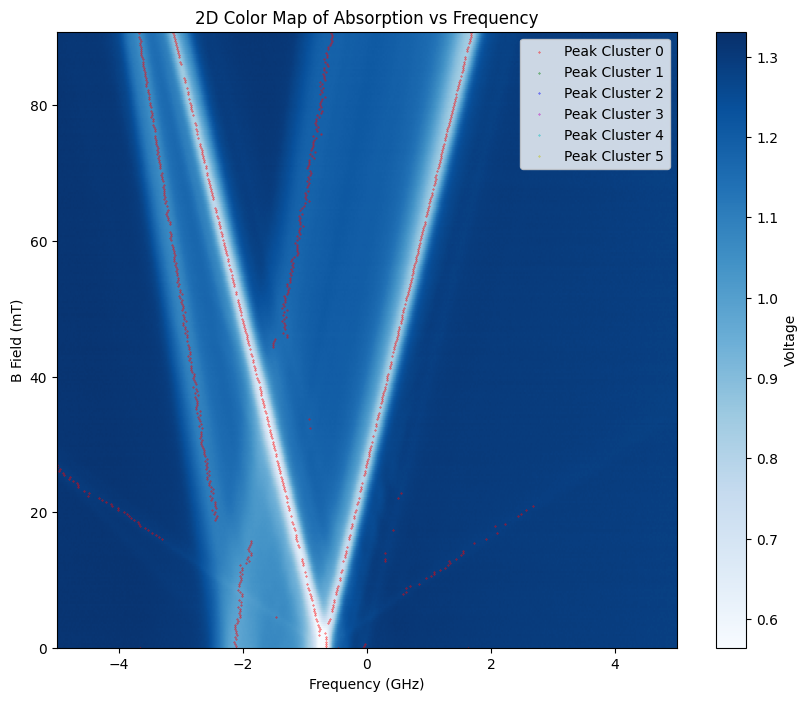

In [152]:
# Plot the 2D colormap of absorption
plt.figure(figsize=(10, 8))
plt.pcolormesh(freq_axis_GHz, fields * 1000, voltages, shading='auto', cmap='Blues')
plt.colorbar(label="Voltage")
plt.xlabel("Frequency (GHz)")
plt.ylabel("B Field (mT)")
plt.title("2D Color Map of Absorption vs Frequency")

# Plot each cluster with a different color
colors = ['r', 'g', 'b', 'm', 'c', 'y', 'k']
for cluster, peaks in peak_clusters.items():
    B_values = peaks[:, 0] * 1000  # Convert to mT
    f_values = peaks[:, 1]
    plt.scatter(f_values, B_values, color=colors[cluster % len(colors)], s=0.1, label=f"Peak Cluster {cluster}")

plt.xlim([-5, 5])
plt.legend()
plt.show()


## Linewidths ## 

## Numerical Fitting ##

0.054429301237297195
-1.7077570476137158

######## Absorption Dip Features ########
Min Frequency (GHz): -1.412830
FWHM (GHz): 1.762186
Baseline (max signal): 1.328654
Dip Value (min signal): 0.634895
Absorption Depth: 0.693759
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.412830
FWHM (GHz): 0.458058
Baseline (max signal): 1.328654
Dip Value (min signal): 0.634895
Absorption Depth: 0.693759
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -1.398084
FWHM (GHz): 0.458058
Baseline (max signal): 1.328654
Dip Value (min signal): 0.634895
Absorption Depth: 0.693759
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.041422
FWHM (GHz): 0.354526
Baseline (max signal): 1.328654
Dip Value (min signal): 0.794669
Absorption Depth: 0.533984
#########################################



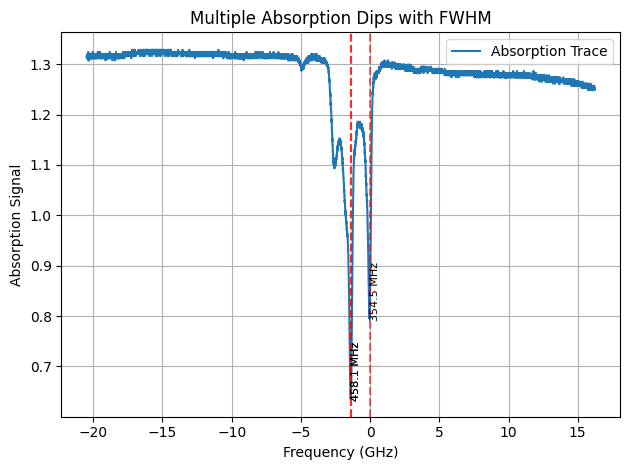

In [28]:
## SINGLE SPECTRUM ## 
# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.335, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([-5,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## Lorentzian Fitting ##


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.422081 GHz
  FWHM:   275.87 MHz
  Depth:  0.5137
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.422081 GHz
  FWHM:   275.87 MHz
  Depth:  0.5137
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.422954 GHz
  FWHM:   284.68 MHz
  Depth:  0.5190
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 1:
  Center: -1.422081 GHz
  FWHM:   275.87 MHz
  Depth:  0.5137
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 2:
  Center: -1.422954 GHz
  FWHM:   284.68 MHz
  Depth:  0.5190
#########################################


######## Absorption Lorentzian Fit Features ########
Dip 3:
  Center: -0.083097 GHz
  FWHM:   350.26 MHz
  Depth:  0.4878
#########################################



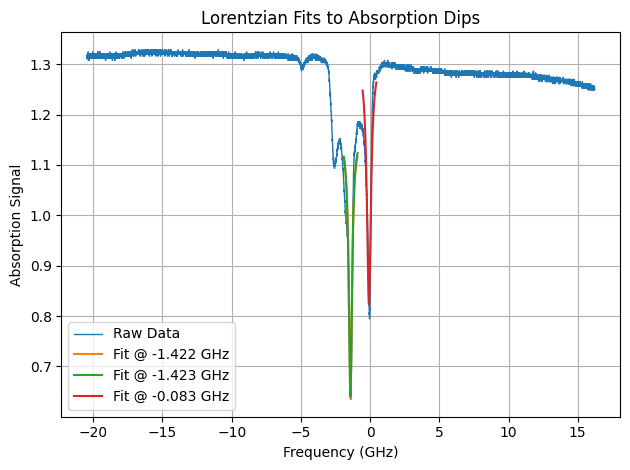

In [53]:
## Lorentzian Fits ##
fits = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=1, min_prominence=0.14, to_print=True)

plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

for f in fits:
    if len(fits)> 5: 
        raise ValueError("WARNING TOO MANY FITS")
    plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz")

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([-5,5])
plt.title("Lorentzian Fits to Absorption Dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Many Lorentzians ##


######## Multi-Lorentzian Fit Features ########
Dip 1:
  Center: -0.824627 GHz
  FWHM:   335.74 MHz
  Depth:  0.6283
#########################################



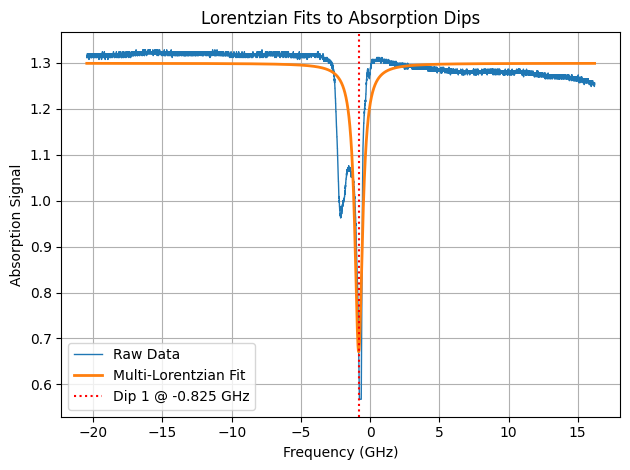

In [16]:
# Perform multi-Lorentzian fit
fit_result = mf.fit_multi_lorentzian_dip(freq_axis_GHz, voltage, window_width=1, min_prominence=0.15, max_lorentzians=10, to_print=True)

# Plot raw data
plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

# Check if fit_result is not None
if fit_result:
    # Plot the combined fit curve
    plt.plot(freq_axis_GHz, fit_result["fit_curve"], label="Multi-Lorentzian Fit", lw=2)

    # Plot individual dip positions
    for i, f in enumerate(fit_result["fits"]):
        plt.axvline(f["f_dip"], color='r', linestyle=':', label=f"Dip {i+1} @ {f['f_dip']:.3f} GHz")

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
plt.title("Lorentzian Fits to Absorption Dips")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Collect Linewidths for All data ## 

In [28]:
data_files =  sorted(glob.glob(data_path +"*"))

voltages = [] 
fields = [] 

for file in data_files: 
    # Step 1: read CSV
    data = pd.read_csv(file, header=None)
    # Extract time, signal, and frequency
    time_axis = data.iloc[0].values.astype(float)
    voltage = data.iloc[1].values.astype(float)
    freq_axis = data.iloc[2].values.astype(float)

    # Convert frequency from Hz to GHz for cleaner axis
    freq_axis_GHz = freq_axis / 1e9

    B_field = read_B_field(file_name=file)
    fields.append(B_field)
    voltages.append(voltage)

fields = np.array(fields)
voltages = np.array(voltages)

# Sort by magnetic fieldusing arg sort
sort_idx = np.argsort(fields)
fields = fields[sort_idx]
voltages = voltages[sort_idx]

In [31]:
linewidths = [] 
for volt in voltages: 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=volt, min_prominence=0.2, to_print=True)
    for f in features: 
        linewidths.append(float(f["FWHM"]))
print(linewidths)



######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.012117
FWHM (GHz): 0.591647
Baseline (max signal): 1.357587
Dip Value (min signal): 0.411390
Absorption Depth: 0.946197
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.080040
FWHM (GHz): 0.804530
Baseline (max signal): 1.371300
Dip Value (min signal): 0.479955
Absorption Depth: 0.891345
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.068981
FWHM (GHz

## Linewidth Change Estimate Start Finish ## 

0.2480385088103575
-0.17956946557663722

######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.427608
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.100587
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.119019
FWHM (GHz): 0.420235
Baseline (max signal): 1.357587
Dip Value (min signal): 0.260547
Absorption Depth: 1.097040
#########################################



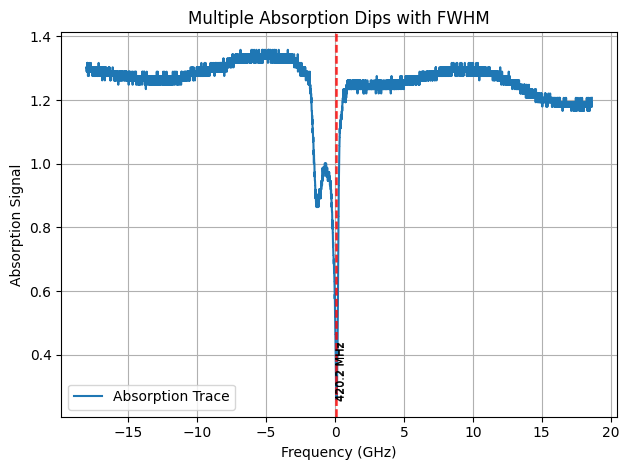

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



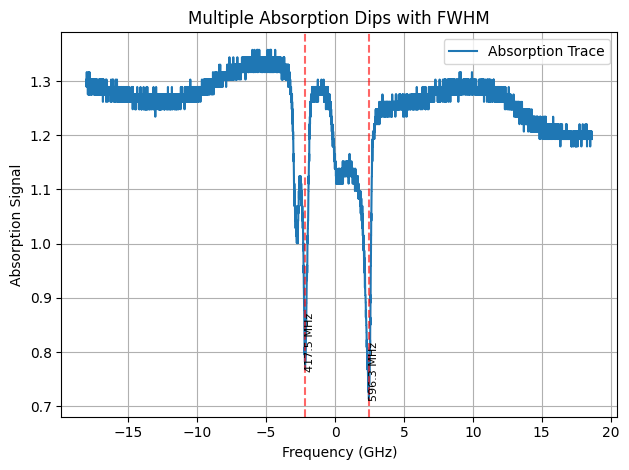

In [39]:
## SINGLE SPECTRUM 1  ## 

data_file1 ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 19-57-37_freq_195.11847_rng_36.6852_gain_30_fld_0.csv"


# Step 1: read CSV
data1 = pd.read_csv(data_file1, header=None)

# Extract time, signal, and frequency
time_axis1 = data1.iloc[0].values.astype(float)
voltage1 = data1.iloc[1].values.astype(float)
freq_axis1 = data1.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz1 = freq_axis1 / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz1, y_data=voltage1, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz1, signal=voltage1, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz1, voltage1, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage1[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_file2 ="data_optics/data_fergus/2025-03-25_IH_line_magnet_ramp/2025-03-25 19-57-37_freq_195.11847_rng_36.6852_gain_30_fld_0.csv"


# Step 1: read CSV
data2 = pd.read_csv(data_file2, header=None)

# Extract time, signal, and frequency
time_axis2 = data2.iloc[0].values.astype(float)
voltage2 = data2.iloc[1].values.astype(float)
freq_axis2 = data2.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz2 = freq_axis2 / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz2, y_data=voltage2, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz2, signal=voltage2, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz2, voltage2, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage2[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



0.6166660729370783
-0.5813735104747628

######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 1.198040
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.268040
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -0.256981
FWHM (GHz): 0.457098
Baseline (max signal): 1.357587
Dip Value (min signal): 0.507381
Absorption Depth: 0.850206
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 0.506078
FWHM (GHz): 0.379686
Baseline (max signal): 1.357587
Dip Value (min signal): 0.617085
Absorption Depth: 0.740502
#########################################



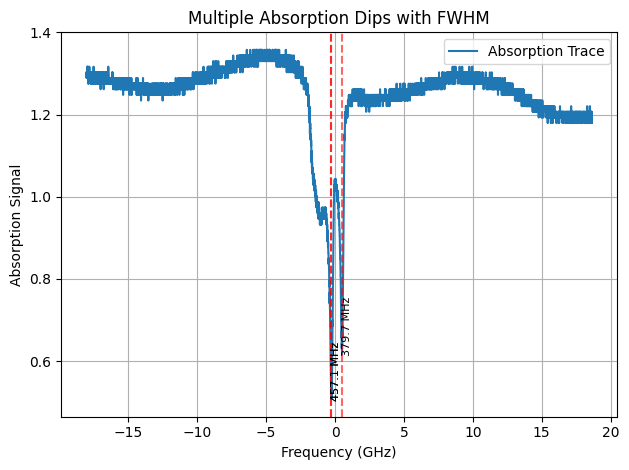

2.618313746145174
-2.8631781324191645

######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 5.481492
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): -2.177531
FWHM (GHz): 0.417471
Baseline (max signal): 1.357587
Dip Value (min signal): 0.767928
Absorption Depth: 0.589659
#########################################


######## Absorption Dip Features ########
Min Frequency (GHz): 2.456118
FWHM (GHz): 0.596255
Baseline (max signal): 1.357587
Dip Value (min signal): 0.713076
Absorption Depth: 0.644511
#########################################



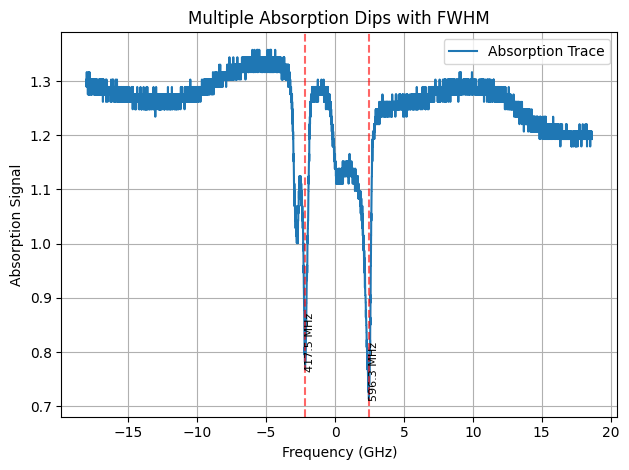

In [40]:
## SINGLE SPECTRUM 1  ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 13-46-29_freq_195.11758_rng_36.6821_gain_30_fld_0.01456.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()


## SINGLE SPECTRUM 2 ## 
data_path = "data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up"
data_file ="data_optics/data_fergus/2025-03-24_IH_line_magnet_ramp_up/2025-03-24 14-10-25_freq_195.11758_rng_36.6821_gain_30_fld_0.08736.csv"


# Step 1: read CSV
data = pd.read_csv(data_file, header=None)

# Extract time, signal, and frequency
time_axis = data.iloc[0].values.astype(float)
voltage = data.iloc[1].values.astype(float)
freq_axis = data.iloc[2].values.astype(float)

# Convert frequency from Hz to GHz for cleaner axis
freq_axis_GHz = freq_axis / 1e9

mf.extract_absorption_features(x_data=freq_axis_GHz, y_data=voltage, to_print=True)
features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=True)


plt.plot(freq_axis_GHz, voltage, label='Absorption Trace')
for f in features:
    plt.axvline(f["f_dip"], color='r', linestyle='--', alpha=0.6)
    plt.text(f["f_dip"], voltage[f["index"]], f"{f['FWHM']*1e3:.1f} MHz", rotation=90, fontsize=8)

plt.xlabel("Frequency (GHz)")
plt.ylabel("Absorption Signal")
#plt.xlim([0,5])
plt.title("Multiple Absorption Dips with FWHM")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



## Linewidth Vs Central Frequency non-Lorentzian ## 

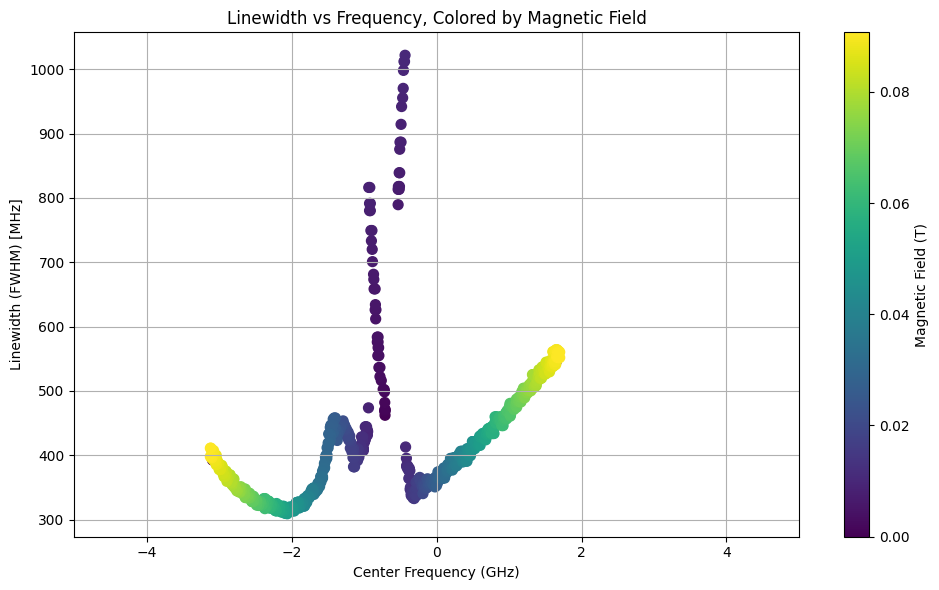

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

# data_files = sorted(glob.glob(data_path + "*"))

# voltages = [] 
# fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

# for file in data_files: 
#     data = pd.read_csv(file, header=None)
#     time_axis = data.iloc[0].values.astype(float)
#     voltage = data.iloc[1].values.astype(float)
#     freq_axis = data.iloc[2].values.astype(float)
#     freq_axis_GHz = freq_axis / 1e9

#     B_field = read_B_field(file_name=file)
#     fields.append(B_field)
#     voltages.append(voltage)

# fields = np.array(fields)
# voltages = np.array(voltages)

# sort_idx = np.argsort(fields)
# fields = fields[sort_idx]
# voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.extract_all_absorption_dips(freq=freq_axis_GHz, signal=voltage, min_prominence=0.2, to_print=False)

    # Plot per-spectrum trace (optional)
    # plt.figure(figsize=(10, 4))
    # plt.plot(freq_axis_GHz, voltage, label=f'B = {B:.4f} T')
    for f in features:
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        index = f["index"]

        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

        # plt.axvline(f_dip, color='r', linestyle='--', alpha=0.6)
        # plt.text(f_dip, voltage[index], f"{fwhm*1e3:.1f} MHz", rotation=90, fontsize=8)

    # plt.xlabel("Frequency (GHz)")
    # plt.ylabel("Absorption Signal")
    # plt.title("Absorption Dips with FWHM")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()

# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50) # edgecolor='k'
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.xlim([-5,5])
plt.title("Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()


## LORENTZIAN VERSION ## 

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob

data_files = sorted(glob.glob(data_path + "*"))

# voltages = [] 
# fields = []

# Storage for linewidth analysis
all_f_dips = []
all_fwhms = []
all_B_fields = []

# for file in data_files: 
#     data = pd.read_csv(file, header=None)
#     time_axis = data.iloc[0].values.astype(float)
#     voltage = data.iloc[1].values.astype(float)
#     freq_axis = data.iloc[2].values.astype(float)
#     freq_axis_GHz = freq_axis / 1e9

#     B_field = read_B_field(file_name=file)
#     fields.append(B_field)
#     voltages.append(voltage)

# fields = np.array(fields)
# voltages = np.array(voltages)

# sort_idx = np.argsort(fields)
# fields = fields[sort_idx]
# voltages = voltages[sort_idx]

# === Extract and store linewidth features === #
for voltage, B in zip(voltages, fields): 
    features = mf.fit_lorentzian_dip(freq_axis_GHz, voltage, window_width=2, min_prominence=0.2, to_print=False)
    
    # Plot per-spectrum trace (optional)
    # plt.figure(figsize=(10, 4))

    # plt.plot(freq_axis_GHz, voltage, label='Raw Data', lw=1)

    for f in features:
        if len(features)> 10: 
            raise ValueError("WARNING TOO MANY FITS")
        # plt.plot(f["f_fit"], f["fit_curve"], label=f"Fit @ {f['f_dip']:.3f} GHz" + f' B = {B:.4f} T')
        f_dip = f["f_dip"]
        fwhm = f["FWHM"]
        all_f_dips.append(f_dip)
        all_fwhms.append(fwhm * 1e3)      # Convert FWHM to MHz
        all_B_fields.append(B)

    # plt.xlabel("Frequency (GHz)")
    # plt.ylabel("Absorption Signal")
    # #plt.xlim([-5,5])
    # plt.title("Lorentzian Fits to Absorption Dips")
    # plt.grid(True)
    # plt.legend()
    # plt.tight_layout()
    # plt.show()



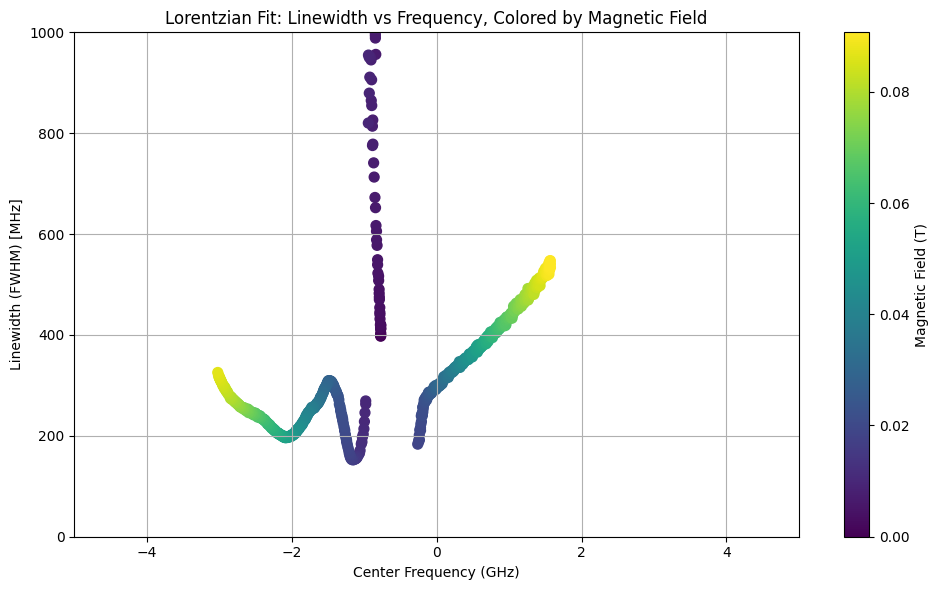

In [33]:
# === Final Plot: Linewidth vs Frequency, colored by B-field === #
plt.figure(figsize=(10, 6))
scatter = plt.scatter(all_f_dips, all_fwhms, c=all_B_fields, cmap='viridis', s=50) #edgecolor='k'
cbar = plt.colorbar(scatter)
cbar.set_label("Magnetic Field (T)")

plt.xlabel("Center Frequency (GHz)")
plt.ylabel("Linewidth (FWHM) [MHz]")
plt.xlim([-5,5])
plt.ylim([0,1000])
plt.title("Lorentzian Fit: Linewidth vs Frequency, Colored by Magnetic Field")
plt.grid(True)
plt.tight_layout()
plt.show()

## Manual Peak Picking ## 